#Implémentation du Psi-score

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import cvxpy as cp


In [2]:
print("Solveurs disponibles :", cp.installed_solvers())

Solveurs disponibles : ['CLARABEL', 'ECOS', 'ECOS_BB', 'MOSEK', 'OSQP', 'SCIPY', 'SCS']


##Paramètres
On commence par générer un **Graphe G=(V,E)** dont la matrice d'adjacence est notée **F**.

In [29]:
n=2000 #nombre de noeuds
p=0.4 #probabilité de création d'une arrête
G = nx.erdos_renyi_graph(n,p, seed = 91,directed=True)
F = nx.to_numpy_array(G, dtype=int)
#F est la matrice d'adjacence du graphe G
print(F)


[[0 1 1 ... 1 0 1]
 [0 0 1 ... 1 0 0]
 [1 1 0 ... 0 1 0]
 ...
 [1 0 0 ... 0 1 0]
 [1 1 0 ... 0 0 0]
 [1 1 0 ... 1 0 0]]


###Visualisation du Graphe

In [ ]:
# plt.figure(figsize=(10, 8))
# pos = nx.spring_layout(G, seed=42)
# nx.draw_networkx_nodes(
#     G,
#     pos,
#     node_size=500,
#     node_color="skyblue",
#     edgecolors="black",
#     linewidths=1
# )
# nx.draw_networkx_edges(
#     G,
#     pos,
#     width=1.5,
#     edge_color="gray",
#     alpha=0.6
# )
# plt.title("Graphe aléatoire Erdos Renyi", fontsize=14)
# plt.axis("off")  # Désactive les axes
# plt.tight_layout()

KeyboardInterrupt: 

<Figure size 1000x800 with 0 Axes>

##Taux
On génére également les **taux  λ(n) et μ(n)** désignant respectivement le taux auquel l'utilisateur n génère de nouvelles publications sur son mur et le taux auquel l'utilisateur n consulte son fil d'actualités et sélectionne l'une des M entrées pour la republier sur son mur.

In [31]:
lambdas = np.random.random(n)
mus = np.random.random(n)

In [32]:
print(lambdas)
print(mus)

[0.44043364 0.51118216 0.52970676 ... 0.75654903 0.32418154 0.20761103]
[0.96374041 0.06739629 0.81225463 ... 0.16483913 0.524376   0.78648572]


In [33]:
value_dict = {i: {'lambda': lambdas[i], 'mu': mus[i]} for i in range(n)}
nx.set_node_attributes(G,value_dict)

In [ ]:
def visualiser_graphe(G, titre="Graphe", taille_fig=(10, 8), couleur_noeuds="skyblue",
                     couleur_aretes="gray", taille_noeuds=500, graphe_aleatoire=True, seed=42):
    """
    Visualise un graphe NetworkX avec les attributs 'lambda' et 'mu' des arêtes.

    Paramètres:
        G (nx.Graph): Le graphe à visualiser.
        titre (str): Titre du graphe.
        taille_fig (tuple): Taille de la figure (largeur, hauteur).
        couleur_noeuds (str): Couleur des nœuds.
        couleur_aretes (str): Couleur des arêtes.
        taille_noeuds (int): Taille des nœuds.
        graphe_aleatoire (bool): Si True, utilise un layout aléatoire reproductible.
        seed (int): Graine pour la reproductibilité.
    """
    plt.figure(figsize=taille_fig)

    # Positionnement des nœuds
    pos = nx.spring_layout(G, seed=seed) if graphe_aleatoire else nx.circular_layout(G)

    # Dessin des nœuds
    nx.draw_networkx_nodes(
        G, pos,
        node_size=taille_noeuds,
        node_color=couleur_noeuds,
        edgecolors="black",
        linewidths=1
    )

    # Dessin des arêtes
    nx.draw_networkx_edges(
        G, pos,
        width=1.5,
        edge_color=couleur_aretes,
        alpha=0.6
    )
    labels = {n: f"λ: {G.nodes[n]['lambda']:.2f}\nμ: {G.nodes[n]['mu']:.2f}" for n in G.nodes}

    nx.draw_networkx_labels(G, pos, font_size=10, labels=labels )

    plt.title(titre, fontsize=14)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

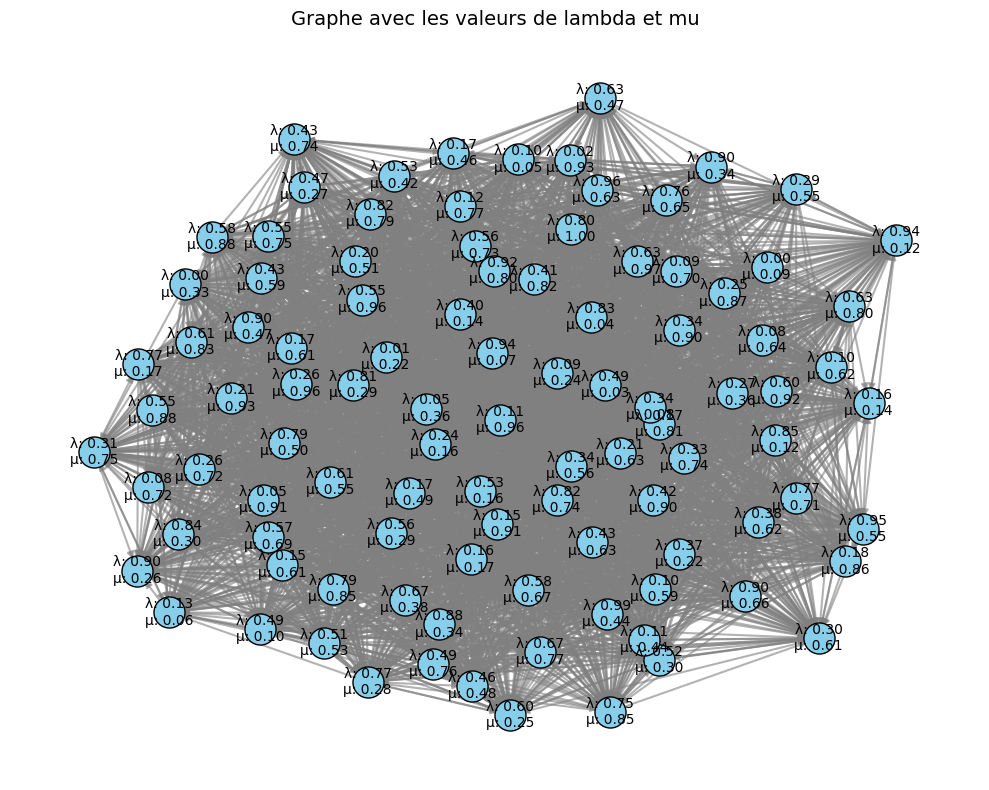

In [ ]:
#visualiser_graphe(G,titre="Graphe avec les valeurs de lambda et mu")

##Matrice de Propagation
Ensuite, nous allons calculer la **matrice de propagation A** ainsi que les vecteurs ${b_i}$ , la matrice C et les vecteurs ${d_i}$  à l'aide des formules ci-dessous.

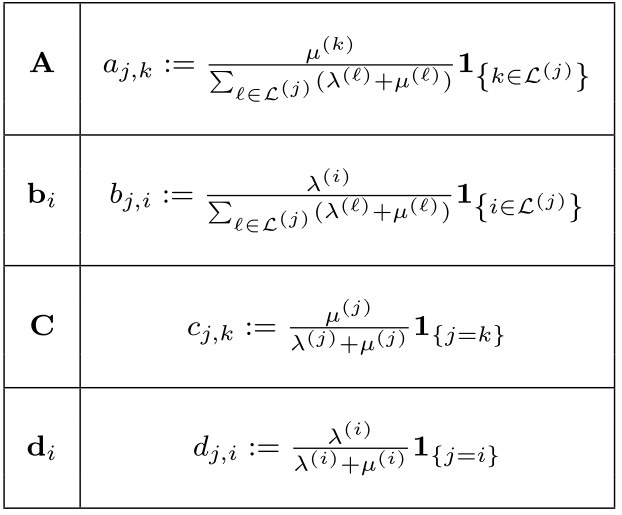

In [34]:
def calcul_A(F, lambda_, mu):
    N = len(F)
    A = np.zeros((N, N))
    for j in range(N):
        denom = sum(lambda_[k] + mu[k] for k in np.where(F[j] == 1)[0])
        for k in np.where(F[j] == 1)[0]:
            if denom > 0:
                A[j, k] = mu[k] / denom
    return A

def calcul_bi(F, lambda_, mu, i):
    N = len(F)
    b = np.zeros(N)
    for j in range(N):
        denom = sum(lambda_[k] + mu[k] for k in np.where(F[j] == 1)[0])
        if i in np.where(F[j] == 1)[0] and denom > 0:
            b[j] = lambda_[i] / denom
    return b

In [35]:
#On met les vecteurs b_i en colonnedans une matrice B
def calcul_B(F, lambda_, mu):
  N = len(F)
  B=np.zeros((N,N))
  for j in range(N):
    B[:,j] = calcul_bi(F, lambda_, mu, j)
  return B

Vérifions que C= disque de rayon spectral et de centre 0 est un fermé borné.

In [36]:
'''Valeurs propres et rayon spectral de A'''
A = calcul_A(F,lambdas,mus)
vp_A = np.linalg.eigvals(A)
rho = max(abs(vp_A))
print(rho)

0.5016987620783476


##Étude de la matrice I-A
Nous allons inverser la matrice I-A afin de l'inverser pour résoudre le système **(I-A)pi=bi**.

In [11]:
'''Construction de I-A'''
A = calcul_A(F,lambdas,mus)
I = np.eye(A.shape[0])
Z = I - A

vp_A = np.linalg.eigvals(A)
rho_A = max(abs(vp_A))
print(rho_A)

0.49740168594010226


In [ ]:
'''Valeurs propres et Rayon spectral de I-A'''
vp_Z = np.linalg.eigvals(Z)
rho = max(abs(vp_Z))
print(rho)

1.1161081601914415


In [ ]:
#On vérifie que rho(I-A) < norme(A)
print(np.linalg.norm(Z))

3.2517329620753217


In [12]:
'''Inverse de la matrice I-A'''
Z_inv = np.linalg.inv(Z)

In [50]:
B = calcul_B(F, lambdas, mus)
#P = Z_inv @ B
print(P)
#On récupère les vecteurs p_i en colonne dans une matrice P


[[0.00340089 0.00800468 0.03125903 ... 0.00614412 0.00856818 0.00817819]
 [0.01321652 0.00186349 0.02907845 ... 0.00652445 0.03310434 0.00723614]
 [0.01421526 0.00223525 0.00839206 ... 0.0232481  0.00939632 0.00774019]
 ...
 [0.00504775 0.00704229 0.00967955 ... 0.00826906 0.00947035 0.00967369]
 [0.00443208 0.00235032 0.02702307 ... 0.02210287 0.00962776 0.02436707]
 [0.0045799  0.00691311 0.02841639 ... 0.00793503 0.00985871 0.00941929]]


In [14]:

def calcul_D(lambda_,mu):
  N=len(lambda_)
  D = np.zeros((N,N))
  for i in range(N):
    for j in range(N):
      if i==j:
        D[i,j]=lambda_[i]/(lambda_[i]+mu[i])
  return D

#print(calcul_D(lambdas,mus))


In [15]:
def calcul_C(lambda_,mu):
  N=len(lambda_)
  C = np.zeros((N,N))
  for i in range(N):
    for j in range(N):
      if i==j:
        C[i,j]=mu[i]/(lambda_[i]+mu[i])
  return C

#print(calcul_C(lambdas,mus))


In [16]:
C = calcul_C(lambdas,mus)
D = calcul_D(lambdas,mus)
Q = C @ P + D
print(Q)
#Q contient en colonnes les vecteurs qi

[[7.36605788e-01 2.11558132e-03 8.26154482e-03 ... 1.62384934e-03
  2.26451123e-03 2.16143778e-03]
 [6.82385168e-03 4.84650035e-01 1.50135573e-02 ... 3.36865372e-03
  1.70921732e-02 3.73610785e-03]
 [4.65620286e-03 7.32153763e-04 6.75199177e-01 ... 7.61490738e-03
  3.07776177e-03 2.53529545e-03]
 ...
 [1.88343203e-03 2.62764236e-03 3.61166610e-03 ... 6.29962016e-01
  3.53360894e-03 3.60948112e-03]
 [5.45204285e-04 2.89120657e-04 3.32419128e-03 ... 2.71894314e-03
  8.78171235e-01 2.99746931e-03]
 [2.21987514e-03 3.35078205e-03 1.37734163e-02 ... 3.84610551e-03
  4.77851346e-03 5.19865833e-01]]


In [75]:
def solve_pi(A, b):
    I = np.eye(len(A))
    try:
        return np.linalg.solve(I - A, b)
    except np.linalg.LinAlgError as e:
        print("Matrix solve failed:", e)
        return None

In [38]:
def calcul_bi(F, lambdas, mus, i):
    n = F.shape[0]
    bi = np.zeros(n)
    for j in range(n):
        if F[i, j] == 1:
            bi[j] += lambdas[i]
        if F[j, i] == 1:
            bi[j] -= mus[i]
    return bi



##Optimisation avec les polynômes de Faber de seconde espèce


In [23]:
def faber_2nd_espèce(A, b, m, a, b_):
    """

    Paramètres:
    - A: matrice (spectre supposé dans K = [a, b_])
    - b: vecteur initial
    - m: degrée d'approximation

    """
    n = len(b)
    I = np.eye(n) #matrice identité
    x = b.copy()
    r = b.copy()

    C = (2 * A - (a + b_) * I) / (b_ - a)
    beta_k = lambda k: 1 / (1 + k)

    for k in range(1, m + 1):
        r = C @ r
        x += beta_k(k) * r

    return x

def psi_score_faber2(F, lambdas, mus, m=30, a=0, b=1):
    """

    Paramètres:
    - F: matrice d'adjacence (n x n)
    - lambdas: tableau contenant les lambdas
    - mus: tableau contenant les mus
    - m: degrée d'approximation

    """
    n = F.shape[0]
    A = F / np.maximum(F.sum(axis=1, keepdims=True), 1)
    psi_scores = []

    for i in range(n):
        b_i = np.zeros(n)
        for j in range(n):
            if F[i, j] == 1:
                b_i[j] += lambdas[i]
            if F[j, i] == 1:
                b_i[j] -= mus[i]

        p_i = faber_2nd_espèce(A, b_i, m, a=a, b_=b)
        psi_scores.append(np.linalg.norm(p_i, 1))  # norme L1

    return np.array(psi_scores)
psi_scores = psi_score_faber2(F, lambdas, mus, m=3, a = -rho_A, b = rho_A)
print(psi_scores)

[ 5.52729919  6.70089412  1.4866915   2.80672497 18.00202978 10.90349056
 16.77490161  5.13351835 10.30951967 33.03727137]


On remarque que plus on augmente le degré d'approximation, plus les psi-score de chaque noeud grandissent.

In [78]:
def richardson(A, B, m):
  n = A.shape[0]
  x = np.random.rand(n,n)
  print(x.shape)
  for i in range(m):
    x = A @ x + B
  return x

x = richardson(A, B, 100)
print(x.shape)
print(P[0])
print(x[0])

(100, 100)
(100, 100)
[7.16963558e-03 3.16250354e-02 3.07968427e-02 5.56251361e-03
 4.73034842e-05 1.15987643e-03 2.57878091e-04 3.34234812e-03
 1.13200118e-03 4.05781834e-03 2.12730224e-02 2.18326367e-03
 2.27546281e-02 8.71962452e-03 3.17210923e-03 3.71990297e-02
 4.85972390e-03 4.29717780e-03 1.97224542e-02 2.24470614e-03
 1.83736000e-03 1.54426803e-03 2.37820148e-02 7.66739054e-03
 1.41913144e-05 3.63910877e-02 2.28237841e-03 3.19705870e-03
 1.42679818e-03 2.11716243e-03 7.29119469e-04 1.44068541e-02
 6.56409496e-03 3.15288637e-02 6.02283841e-03 1.00147206e-02
 2.31345943e-02 2.68313597e-02 2.23956467e-02 4.32192628e-03
 1.62098831e-02 1.95742416e-02 9.93783121e-03 1.90812461e-02
 7.31404499e-04 3.40308087e-03 5.38293072e-03 4.17017891e-03
 1.08188149e-02 7.98352474e-03 8.80235194e-03 5.08935584e-03
 6.99529908e-03 8.33656761e-03 4.89937786e-04 3.01761343e-02
 1.06460255e-03 6.03694325e-03 3.04251609e-03 7.93802176e-03
 7.17051365e-03 1.14373056e-02 2.39320308e-03 3.52070022e-02
 3

##Visualisation des valeurs propres

In [39]:
eigvals = np.linalg.eigvals(A)
print(eigvals)

[ 5.01698762e-01+0.00000000e+00j  1.28244398e-02+8.91567881e-03j
  1.28244398e-02-8.91567881e-03j ... -3.85380847e-05+1.79916444e-05j
 -3.85380847e-05-1.79916444e-05j  8.45636570e-06+0.00000000e+00j]


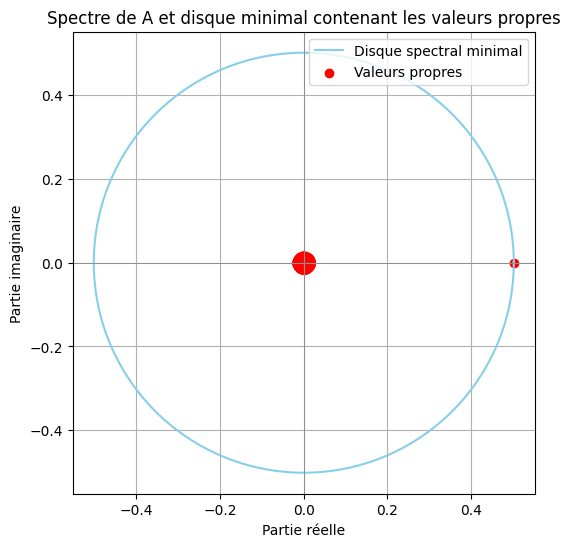

In [40]:
def plot_spectrum_and_optimal_disk(A):
    """
    Affiche les valeurs propres d'une matrice A dans le plan complexe,
    ainsi que le plus petit disque centré sur le barycentre spectral contenant toutes les valeurs propres.
    """
    eigvals = np.linalg.eigvals(A)
    real_parts = eigvals.real
    imag_parts = eigvals.imag

    center = np.mean(eigvals)
    radius = max(abs(eigvals - center))

    theta = np.linspace(0, 2 * np.pi, 400)
    circle_x = center.real + radius * np.cos(theta)
    circle_y = center.imag + radius * np.sin(theta)

    plt.figure(figsize=(6, 6))
    plt.plot(circle_x, circle_y, label='Disque spectral minimal', color='skyblue')
    plt.scatter(real_parts, imag_parts, color='red', label='Valeurs propres')
    plt.axhline(0, color='gray', lw=0.5)
    plt.axvline(0, color='gray', lw=0.5)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title("Spectre de A et disque minimal contenant les valeurs propres")
    plt.xlabel("Partie réelle")
    plt.ylabel("Partie imaginaire")
    plt.legend()
    plt.grid(True)
    plt.show()

A = calcul_A(F,lambdas,mus)
plot_spectrum_and_optimal_disk(A)


In [47]:
#Ne marche pas à cause d'un problème d'installation de solveur
def find_optimal_circle(eigenvalues):
    n = len(eigenvalues)
    R = cp.Variable(nonneg=True)
    x_c = cp.Variable()
    y_c = cp.Variable()

    constraints = []
    for i in range(n):
        l_real = eigenvalues[i].real
        l_imag = eigenvalues[i].imag
        # Correction : créer un vecteur avec les différences
        diff = cp.vstack([l_real - x_c, l_imag - y_c])
        constraints.append(cp.norm(diff, 2) <= R)

    problem = cp.Problem(cp.Minimize(R), constraints)
    problem.solve(solver='ECOS')

    if problem.status != 'optimal':
        raise ValueError("Le problème n'a pas convergé vers une solution optimale.")

    return R.value, x_c.value, y_c.value

R, x_c, y_c = find_optimal_circle(eigvals)
print(R, x_c, y_c)

0.25884523102671586 0.24285353103058266 -9.316376658961194e-11


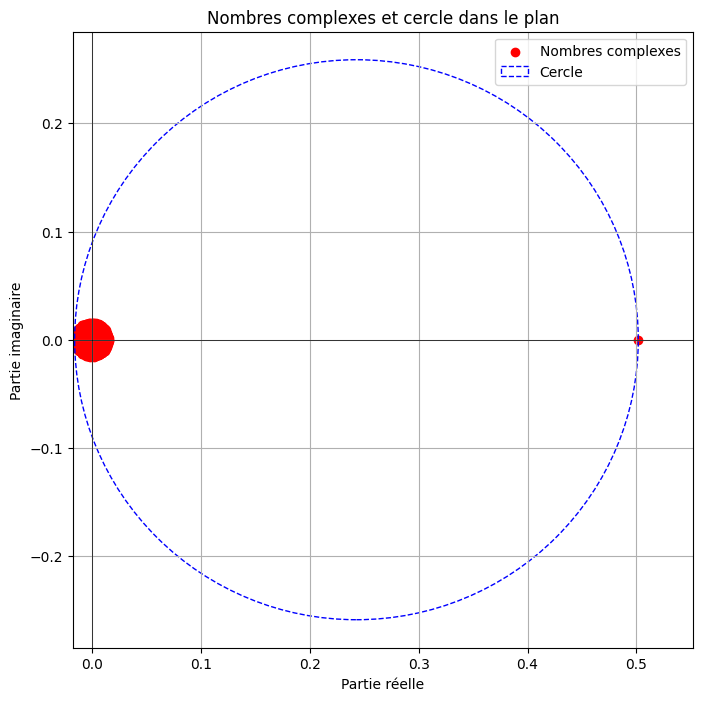

In [46]:


# Extraire parties réelles et imaginaires des nombres complexes
x = [z.real for z in eigvals]
y = [z.imag for z in eigvals]

# Créer la figure
plt.figure(figsize=(8, 8))
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.xlabel('Partie réelle')
plt.ylabel('Partie imaginaire')
plt.title('Nombres complexes et cercle dans le plan')

# Tracer les points
plt.scatter(x, y, color='red', label='Nombres complexes')

# Tracer le cercle
cercle = plt.Circle((x_c, y_c), R, fill=False, color='blue', linestyle='--', label='Cercle')
plt.gca().add_patch(cercle)

# Ajuster les limites des axes pour bien voir le cercle
plt.xlim((x_c - R)*1.1, (x_c + R) * 1.1)
plt.ylim((y_c - R)*1.1, (y_c + R)*1.1)

# Afficher la légende
plt.legend()

# Afficher le graphique
plt.show()

In [51]:
n = A.shape[0]
x_n = np.random.rand(n)
x_n1 = A @ x_n + B
print(B.shape)

(2000, 2000)


In [54]:
def richardson_counted(A, B, e):
  i = 0
  n = A.shape[0]
  x_n = np.random.rand(n,n)
  x_n1 = A @ x_n + B
  while(np.linalg.norm(x_n - x_n1) > e):
    i+=1
    x_n = x_n1
    x_n1 = A @ x_n + B
    
  return x_n1, i

# x, i = richardson_counted(A,B,1e-9)
# print(x[0])
# print(P[0])
# print(i)


In [56]:
def richardson_not_centered(A,B,e,x_c,y_c,R):
    i = 0
    n = A.shape[0]
    a = np.cdouble(x_c,y_c)
    if np.abs(1 - a) <= R:
        raise np.linalg.LinAlgError("1 belongs to the disc")
    gamma = 1/(1 - a)

    x_n = np.random.rand(n,n)
    x_n1 = gamma*A @ x_n + (1 - gamma)*x_n + gamma*B
    while(np.linalg.norm(x_n - x_n1) > e):
        i+=1
        x_n = x_n1
        x_n1 = gamma*A @ x_n + (1 - gamma)*x_n + gamma*B
        
    return x_n1, i

# x, i = richardson_not_centered(A,B,1e-9,x_c,y_c,R)
# print(x[0])
# print(P[0])
# print(i)

In [57]:
def compare_iterations(A, B, xc, yc, R, tolerance_range=np.logspace(-2, -10, 9)):
    """
    Compare le nombre d'itérations des deux méthodes de Richardson
    
    Args:
        A, B: Matrices du problème
        xc, yc, R: Paramètres du cercle pour la méthode non centrée
        tolerance_range: Plage de tolérances à tester
    """
    results = {
        'tolerance': [],
        'method1_iter': [],
        'method2_iter': []
    }
    
    for e in tolerance_range:
        # Méthode standard
        try:
            _, iter1 = richardson_counted(A, B, e)
        except Exception as err:
            print(f"Erreur méthode standard avec tolérance {e}: {err}")
            iter1 = np.nan
        
        # Méthode non centrée
        try:
            _, iter2 = richardson_not_centered(A, B, e, xc, yc, R)
        except np.linalg.LinAlgError as err:
            print(f"Erreur méthode non centrée avec tolérance {e}: {err}")
            iter2 = np.nan
        except Exception as err:
            print(f"Erreur inattendue méthode non centrée: {err}")
            iter2 = np.nan
        
        # Stockage des résultats
        results['tolerance'].append(e)
        results['method1_iter'].append(iter1)
        results['method2_iter'].append(iter2)
    
    # Affichage des résultats
    plt.figure(figsize=(10, 6))
    
    # Graphique des itérations
    plt.semilogx(results['tolerance'], results['method1_iter'], 'bo-', label='Méthode standard')
    plt.semilogx(results['tolerance'], results['method2_iter'], 'ro-', label='Méthode non centrée')
    plt.xlabel('Tolérance (échelle log)')
    plt.ylabel('Nombre d\'itérations')
    plt.title('Comparaison du nombre d\'itérations nécessaires')
    plt.legend()
    plt.grid(True, which="both", ls="-")
    
    # Affichage des valeurs numériques
    print("\nRésultats détaillés:")
    print("Tolérance\tItérations (standard)\tItérations (non centrée)")
    for i in range(len(results['tolerance'])):
        print(f"{results['tolerance'][i]:.2e}\t{results['method1_iter'][i]}\t\t\t{results['method2_iter'][i]}")
    
    plt.tight_layout()
    filename = "comparaison_methodes_richardson.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"\nFigure sauvegardée sous {filename}")
    plt.show()
    
    return results


Résultats détaillés:
Tolérance	Itérations (standard)	Itérations (non centrée)
1.00e-02	16			11
1.00e-03	20			13
1.00e-04	23			16
1.00e-05	26			18
1.00e-06	30			20
1.00e-07	33			22
1.00e-08	36			24
1.00e-09	40			26
1.00e-10	43			28

Figure sauvegardée sous comparaison_methodes_richardson.png


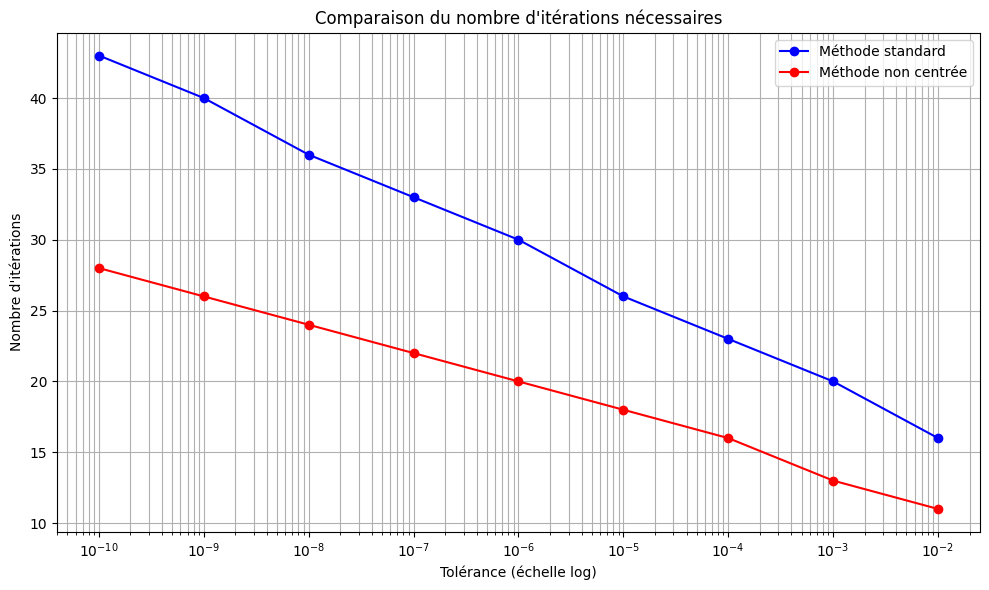

{'tolerance': [np.float64(0.01),
  np.float64(0.001),
  np.float64(0.0001),
  np.float64(1e-05),
  np.float64(1e-06),
  np.float64(1e-07),
  np.float64(1e-08),
  np.float64(1e-09),
  np.float64(1e-10)],
 'method1_iter': [16, 20, 23, 26, 30, 33, 36, 40, 43],
 'method2_iter': [11, 13, 16, 18, 20, 22, 24, 26, 28]}

In [58]:
compare_iterations(A,B,x_c,y_c,R)